In [75]:
%config Completer.use_jedi = False
import sys
sys.path.append('../pyecog2')
sys.path.append('../')
from ProjectClass import Project,FileBuffer
from main import MainModel
import json
import feature_extractor 
import importlib
importlib.reload(feature_extractor)
FeatureExtractor = feature_extractor.FeatureExtractor

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import spectrotools as spec
importlib.reload(spec)
from numba import jit, njit
import timeit

from scipy import stats

In [110]:
main_model = MainModel()
project=Project(main_model=main_model)
project.load_from_json('/media/mfpleite/LaCie_1/ML_pyecog_2/AwesomeProject.pyecog')
fe = FeatureExtractor()

[]
copy from - history reset
[]
copy from - history reset
[]
copy from - history reset
[]
copy from - history reset
looking for h5_119
[]
copy from - history reset
['seizure', 'artefact', 'flatline', 'baseline']
copy from - history reset
current animal: h5_119


In [115]:
annotation0 = project.current_animal.annotations.annotations_list[1]
it = project.current_animal.eeg_init_time
index = [i  for i in range(len(it)) if (0<(annotation0.getStart()-it[i])<3600) ][0]
# index=0
fname = '.'.join(project.current_animal.eeg_files[index].split('.')[:-1]+['features'])
# fname ='/media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1566408624_2019-08-21-18-30-24_tids_[119].features'

f_vec = np.fromfile(fname,dtype='float64')

fmeta_file = '.'.join(project.current_animal.eeg_files[index].split('.')[:-1] + ['fmeta'])
fmeta_dict = json.load(open(fmeta_file))


In [116]:
f_vec = f_vec.reshape((-1,fe.settings['number_of_features']))
f_vec[np.where(np.isnan(f_vec))] = 0

In [117]:
starts = [(annotation0.getStart()-it[index])/2.5 for annotation0 in project.current_animal.annotations.annotations_list]
ends = [(annotation0.getEnd()-it[index])/2.5 for annotation0 in project.current_animal.annotations.annotations_list]

f_labels = np.zeros(len(f_vec),dtype='bool')
for i in range(len(starts)-1) :
    s = int(np.floor(starts[i+1]))
    e = int(np.ceil(ends[i+1]))
    f_labels[s:e] = 1
    
f_vec_d  = np.hstack([f_vec,np.vstack([np.zeros(f_vec.shape[1]),np.diff(f_vec,axis=0)])])
f_vec_d  = f_vec
f_vec_d = f_vec_d-np.mean(f_vec_d,axis=0)
f_vec_d = f_vec_d/np.std(f_vec_d,axis = 0)

blanks = f_vec_d#[(1-f_labels).nonzero()[0],:]
seizures = f_vec_d[(f_labels).nonzero()[0],:]

blanks_mu  = blanks.mean(axis=0)
blanks_cov = (blanks-blanks_mu).T.dot((blanks-blanks_mu))/blanks.shape[0]
seizures_mu  = seizures.mean(axis=0)
seizures_cov = (seizures-seizures_mu).T.dot((seizures-seizures_mu))/seizures.shape[0]

[Text(0, 0, 'min'),
 Text(0, -1, 'max'),
 Text(0, -2, 'mean'),
 Text(0, -3, 'log std'),
 Text(0, -4, 'kurtosis'),
 Text(0, -5, 'skewness'),
 Text(0, -6, 'log coastline (log sum of abs diff)'),
 Text(0, -7, 'log powerf(1, 4)'),
 Text(0, -8, 'log powerf(4, 8)'),
 Text(0, -9, 'log powerf(8, 12)'),
 Text(0, -10, 'log powerf(12, 30)'),
 Text(0, -11, 'log powerf(30, 50)'),
 Text(0, -12, 'log powerf(50, 70)'),
 Text(0, -13, 'log powerf(70, 120)'),
 Text(0, -14, 'fentropy')]

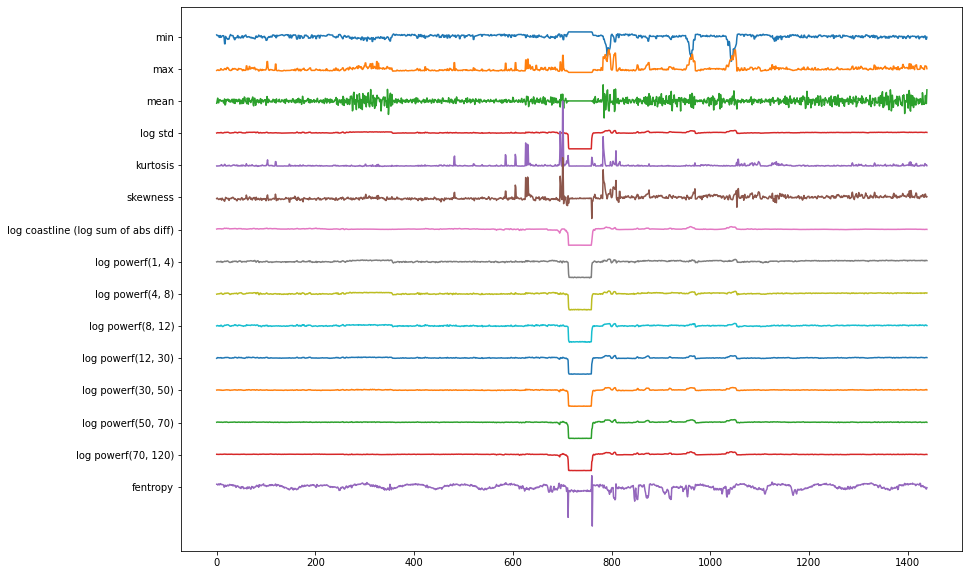

In [118]:

f = plt.figure(figsize=(14,10))
ax = f.gca()
spec.plot_spread(f_vec_d,.5);

# plt.xlim([400,1000])
# plt.vlines(starts[1:],-15,0)
# plt.vlines(ends[1:],-15,0)
ax.set_yticks(range(0,-fe.settings['number_of_features'],-1))
ax.set_yticklabels(fe.settings['feature_labels'])

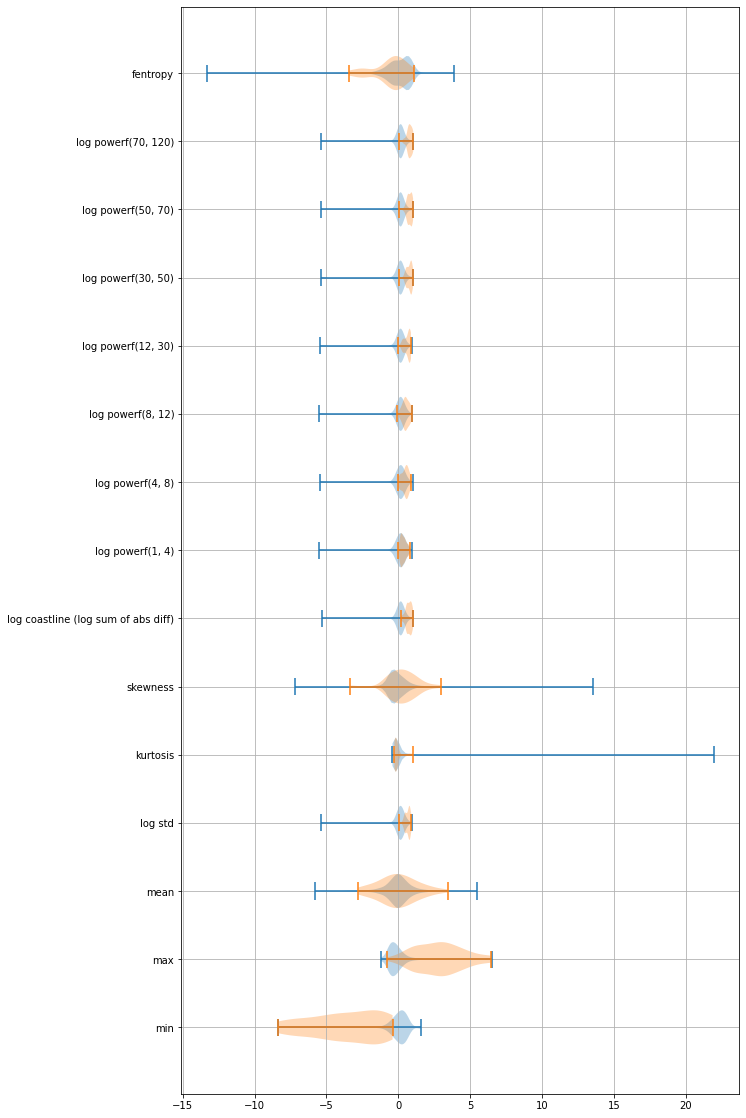

In [119]:
plt.figure(figsize=(10,20))
plt.violinplot(blanks,vert=False);
plt.violinplot(seizures,vert=False);
ax=plt.gca()
# ax.set_yticks(list(range(1,fe.settings['number_of_features']+1,1)) + 
#               list(range(fe.settings['number_of_features']+1,2*fe.settings['number_of_features']+1,1)))
# ax.set_yticklabels(fe.settings['feature_labels'] + ['d'+s+'/dt' for s in fe.settings['feature_labels']])
ax.set_yticks(list(range(1,fe.settings['number_of_features']+1,1)))
ax.set_yticklabels(fe.settings['feature_labels'])
plt.grid()

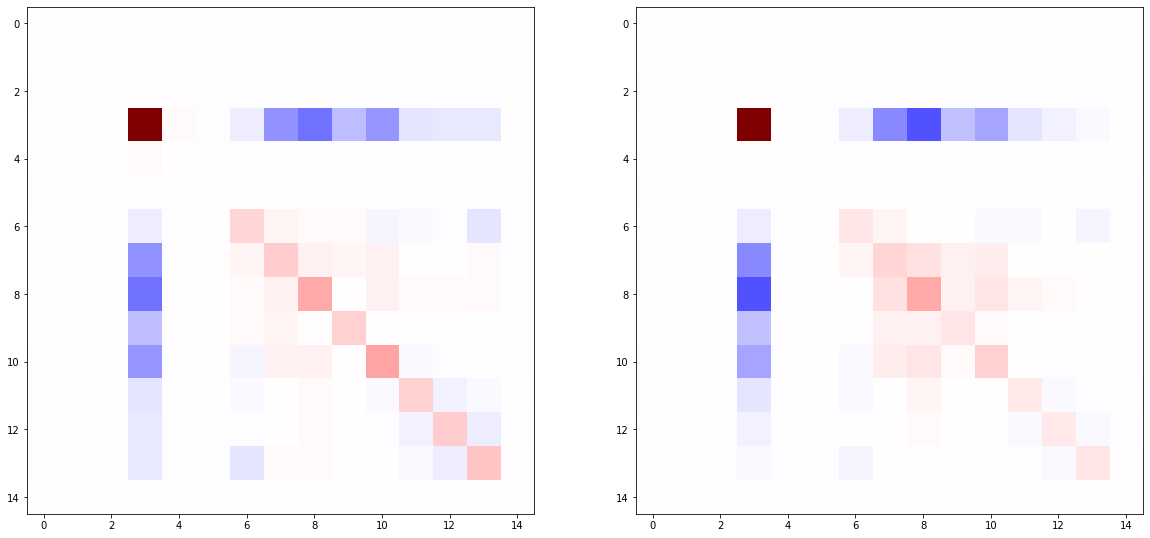

In [90]:
blanks_cov_i = np.linalg.inv(blanks_cov)
seizures_cov_i = np.linalg.inv(seizures_cov)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(blanks_cov_i,cmap='seismic',vmin=-np.max(np.abs(blanks_cov_i)),vmax=np.max(np.abs(blanks_cov_i)))
plt.subplot(1,2,2)
plt.imshow(seizures_cov_i,cmap='seismic',vmin=-np.max(np.abs(seizures_cov_i)),vmax=np.max(np.abs(seizures_cov_i)))

In [91]:
fe.settings['feature_labels']

['min',
 'max',
 'mean',
 'log std',
 'kurtosis',
 'skewness',
 'log coastline (log sum of abs diff)',
 'log powerf(1, 4)',
 'log powerf(4, 8)',
 'log powerf(8, 12)',
 'log powerf(12, 30)',
 'log powerf(30, 50)',
 'log powerf(50, 70)',
 'log powerf(70, 120)',
 'fentropy']

In [92]:
@jit(nopython=True)
def MVGD_LL_jit(fdata,mu,inv_cov,LL,no_scale):
    k = fdata.shape[1]
    N = fdata.shape[0]
    scale = (1-no_scale)*((-k/2)*np.log(2*np.pi)+1/2*np.log(np.linalg.det(inv_cov[:,:])))
    for i in range(N):
        LL[i] = scale - 0.5*(fdata[i,:]-mu)@(inv_cov[:,:] @(fdata[i,:]-mu).T)

def MVGD_LL(fdata,mu,inv_cov,no_scale = False):
    LL = np.zeros(fdata.shape[0])
    MVGD_LL_jit(fdata,mu,inv_cov,LL, no_scale)
    return LL

@jit(nopython=True)
def LL2prob_jit(LL,prob):
    for i in range(LL.shape[0]):
        v = np.exp(LL[i,:])
        prob[i,:] = v / np.sum(v)
        
def LL2prob(LL):
    prob = np.zeros(LL.shape)
    LL2prob_jit(LL,prob)
    return prob

<ipython-input-92-da9e4bc747e3>:7: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  LL[i] = scale - 0.5*(fdata[i,:]-mu)@(inv_cov[:,:] @(fdata[i,:]-mu).T)
/home/mfpleite/anaconda3/envs/pyecog2/lib/python3.8/site-packages/numba-0.52.0-py3.8-linux-x86_64.egg/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  warnings.warn(NumbaPerformanceWarning(msg))


(-500.0, 400.0)

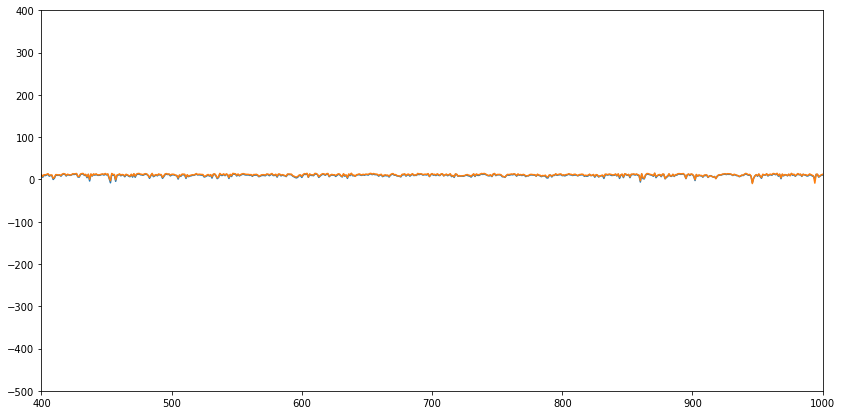

In [93]:
blanks_cov_i = np.linalg.inv(blanks_cov)
blanks_cov_ir = np.linalg.inv(blanks_cov+np.eye(len(blanks_cov))*blanks_cov.diagonal()/len(blanks))

seizures_cov_i = np.linalg.inv(seizures_cov)
seizures_cov_ir = np.linalg.inv(seizures_cov+np.eye(len(seizures_cov))*seizures_cov.diagonal()/len(seizures))

b_LL = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_i)
s_LL = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_i)
b_LLr = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_ir)
s_LLr = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_ir)

plt.figure(figsize=(14,7))
# plt.plot(b_LL)
plt.plot(b_LLr)
# plt.plot(s_LL)
plt.plot(s_LLr)
plt.vlines(starts[1:],-2000,0,linestyles=':')
plt.vlines(ends[1:],-2000,0,linestyles=':')

plt.xlim(400,1000)
plt.ylim(-500,400)

(400.0, 1000.0)

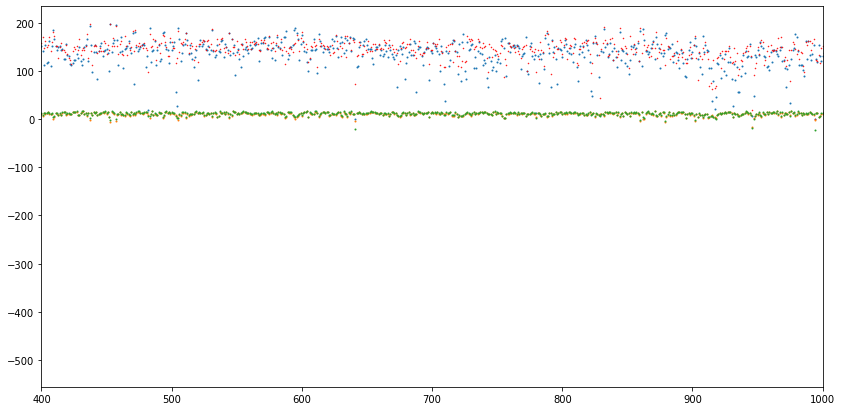

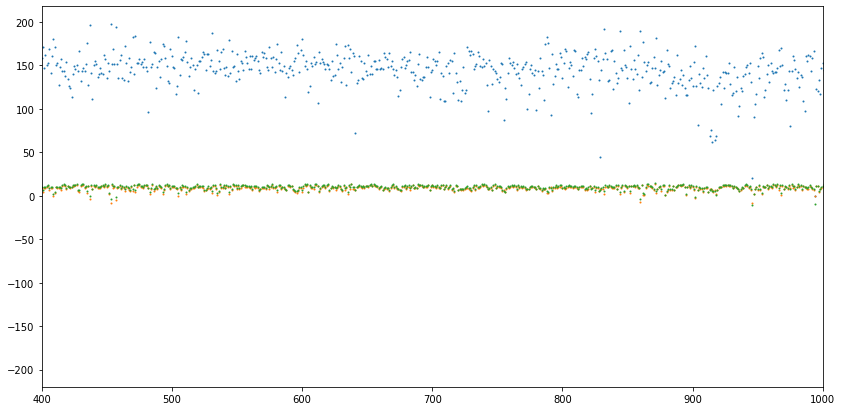

In [94]:
blanks_LL = MVGD_LL(blanks,blanks_mu,blanks_cov_i,no_scale=True)
seizures_LL = MVGD_LL(seizures,seizures_mu,seizures_cov_i,no_scale=True)

blank_bias = np.log(len(blanks)/(len(blanks)+len(seizures)))
seizure_bias = np.log(len(seizures)/(len(blanks)+len(seizures)))


b_LL = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_i)+ blank_bias
s_LL = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_i)+ seizure_bias
b_LLr = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_ir) + blank_bias
s_LLr = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_ir) + seizure_bias

LL = np.array([b_LL.T,s_LL.T]).T
p  = LL2prob(LL) 

LLr = np.array([b_LLr.T,s_LLr.T]).T
pr  = LL2prob(LLr) 

plt.figure(figsize=(14,7))
plt.plot(p[:,1]*200,'.',markersize=2)
plt.plot(pr[:,1]*200,'.',markersize=1,color = [1,0,0,1])
plt.plot(b_LL,'.',markersize=2)
plt.plot(s_LL,'.',markersize=2)
plt.vlines(starts[1:],-200,0,linestyles=':')
plt.vlines(ends[1:],-200,0,linestyles=':')
plt.xlim(400,1000)

plt.figure(figsize=(14,7))
plt.plot(pr[:,1]*200,'.',markersize=2)
plt.plot(b_LLr,'.',markersize=2)
plt.plot(s_LLr,'.',markersize=2)
plt.vlines(starts[1:],-200,0,linestyles=':')
plt.vlines(ends[1:],-200,0,linestyles=':')
plt.xlim(400,1000)

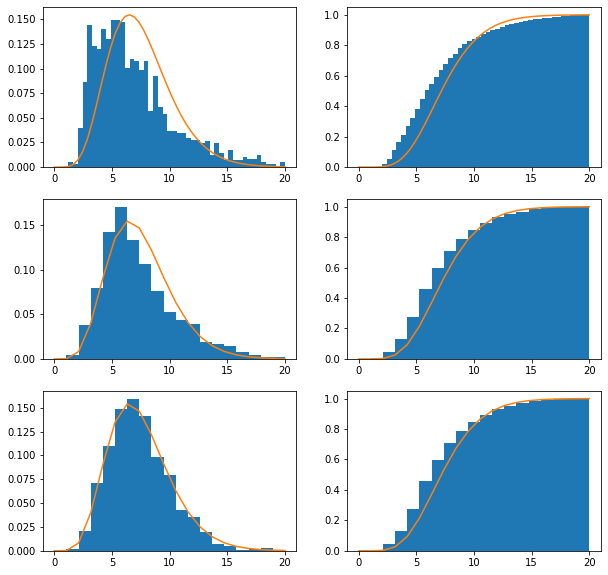

In [95]:
plt.figure(figsize=(10,10))
dof = f_vec.shape[1]
x = np.linspace(0,20,50)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
plt.subplot(321)
plt.hist(-blanks_LL,bins = x,density = True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(322)
plt.hist(-blanks_LL,bins = x,density = True,cumulative=True);
plt.plot(x,cum_chi2)

x = np.linspace(0,20,20)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
# plt.figure()
plt.subplot(323)
plt.hist(-seizures_LL,bins=x,density=True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(324)
plt.hist(-seizures_LL,bins = x,density=True,cumulative=True);
plt.plot(x,cum_chi2)


f_rand = np.random.randn(*f_vec.shape)
LL_rand = 0.5*np.sum(f_rand**2,axis = 1)
x = np.linspace(0,20,20)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
# plt.figure()
plt.subplot(325)
plt.hist(LL_rand,bins=x,density=True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(326)
plt.hist(-seizures_LL,bins = x,density = True,cumulative=True);
plt.plot(x,cum_chi2)





In [173]:
import classifier
importlib.reload(classifier)

<module 'classifier' from '../pyecog2/classifier.py'>

In [174]:
GC = classifier.GaussianClassifier(project,fe,['seizure'])
GC.labels2classify = ['seizure']

In [175]:
GC.train(project.animal_list[0:1])

Training with animal: h5_119
Transitions:19 file: 1709 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1572561642_2019-10-31-22-40-42_tids_[119].featuresmedia/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1569131359_2019-09-22-06-49-19_tids_[119].features of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1572493242_2019-10-31-03-40-42_tids_[119].features
 [[0. 6.]
 [6. 0.]]
HMM.A:
 [[9.99997562e-01 2.43796794e-06]
 [4.22535211e-02 9.57746479e-01]]


In [176]:
GC._debug_f_vec_d.shape

AttributeError: 'GaussianClassifier' object has no attribute '_debug_f_vec_d'

In [ ]:
f = plt.figure(figsize=(14,10))
ax = f.gca()
spec.plot_spread(GC._debug_f_vec_d[:,-4:],.5);

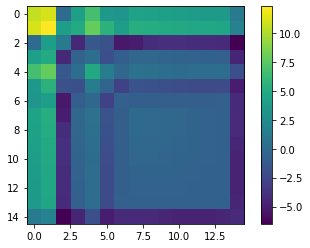

In [178]:
plt.imshow(np.log(np.abs(GC.blank_cov)))
plt.colorbar()

In [179]:
(LLv,R2v,pf,timev) = GC.classify_animal(project.current_animal,100)

../pyecog2/classifier.py:24: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, F))
  LL[i] =( scale - 0.5*(fdata[i,:]-mu)@(inv_cov[:,:] @(fdata[i,:]-mu).T))[0,0]  # the [0,0] is for numba wizzardry to work
/home/mfpleite/anaconda3/envs/pyecog2/lib/python3.8/site-packages/numba-0.52.0-py3.8-linux-x86_64.egg/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, F))
  warnings.warn(NumbaPerformanceWarning(msg))


Animal: h5_119 file: 1709 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1572561642_2019-10-31-22-40-42_tids_[119].fmeta5_119 file: 114 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1566819024_2019-08-26-12-30-24_tids_[119].fmeta /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1567092624_2019-08-29-16-30-24_tids_[119].fmeta h5_119 file: 414 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1567896559_2019-09-07-23-49-19_tids_[119].fmeta1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1568094559_2019-09-10-06-49-19_tids_[119].fmeta /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1568195359_2019-09-11-10-49-19_tids_[119].fmeta h5_119 file: 584 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1568512159_2019-09-15-02-49-19_tids_[119].fmeta h5_119 file: 611 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1568609359_2019-09-16-05-49-19_tids_[119].fmeta h5_119 file: 667

start,end,confidence 128293 128294 17.369258364944617
start,end,confidence 128296 128297 15.582244887598476
start,end,confidence 128330 128331 12.495548534491595
start,end,confidence 128332 128334 36.58814758803078
start,end,confidence 128336 128337 19.873880222593698
start,end,confidence 128339 128340 20.66545297940159
start,end,confidence 128344 128347 59.99539278253808
start,end,confidence 128360 128361 16.29710447906486
start,end,confidence 128362 128364 51.87848923143428
start,end,confidence 128366 128371 115.26139330060606
start,end,confidence 128375 128377 38.08956068292436
start,end,confidence 128380 128382 47.469076811525376
start,end,confidence 128383 128385 42.83112029534488
start,end,confidence 128409 128410 0.4064668339886827
start,end,confidence 128415 128420 115.02980882948438
start,end,confidence 128421 128425 77.88751327950351
start,end,confidence 128427 128428 21.37964797316752
start,end,confidence 128429 128430 10.584441748626869
start,end,confidence 128432 128442 15

start,end,confidence 299187 299189 8.115294594588413
start,end,confidence 299209 299210 9.92942598082049e-05
start,end,confidence 299211 299220 105.54127023957372
start,end,confidence 299221 299222 13.487005274039884
start,end,confidence 299223 299229 61.91948767704668
start,end,confidence 299230 299233 55.64185973249695
start,end,confidence 299365 299402 480.7507325261876
start,end,confidence 299457 299466 32.76219951238006
start,end,confidence 299477 299484 62.85308450350222
start,end,confidence 299525 299536 36.57122036476015
start,end,confidence 299542 299550 89.77978907239107
start,end,confidence 299570 299582 22.706276481926864
start,end,confidence 299583 299584 15.436879288413197
start,end,confidence 299719 299723 3.603623460104354
start,end,confidence 299724 299725 4.291011839371622
start,end,confidence 299728 299739 42.565456964557754
start,end,confidence 303234 303236 0.8812087444147808
start,end,confidence 303332 303334 11.20466205437888
start,end,confidence 312299 312302 12

start,end,confidence 593136 593148 206.05814301761822
start,end,confidence 593149 593151 45.08887871592198
start,end,confidence 593169 593177 112.99208692346429
start,end,confidence 593211 593213 14.386936480123673
start,end,confidence 593217 593228 156.0685074050668
start,end,confidence 593250 593259 130.35223677128909
start,end,confidence 593285 593301 243.37347520593931
start,end,confidence 593326 593336 92.55878403289348
start,end,confidence 593347 593359 77.15712451793854
start,end,confidence 595567 595570 25.13447433698893
start,end,confidence 595952 595955 20.696933721269232
start,end,confidence 597287 597290 3.6680091542012883
start,end,confidence 598482 598484 10.791926157287245
start,end,confidence 598520 598522 7.356466833041885
start,end,confidence 598941 598944 1.4664281823427974
start,end,confidence 599384 599388 35.146593665411
start,end,confidence 599673 599676 10.404843985925869
start,end,confidence 604595 604599 19.730413816383024
start,end,confidence 605143 605145 2.

start,end,confidence 912621 912624 14.427033227950172
start,end,confidence 912640 912644 5.355338699261766
start,end,confidence 912835 912838 7.1318595477292295
start,end,confidence 913508 913511 21.833331012386736
start,end,confidence 913744 913747 25.992293621545453
start,end,confidence 914345 914350 7.073400069748675
start,end,confidence 914500 914503 13.776239316138934
start,end,confidence 915087 915089 6.984829190215276
start,end,confidence 915666 915668 11.620791756337923
start,end,confidence 917388 917390 4.684459854518687
start,end,confidence 917847 917849 8.759026566541793
start,end,confidence 918071 918074 2.8827592570121245
start,end,confidence 918316 918317 8.275614657230033
start,end,confidence 920179 920180 0.0005552837075768051
start,end,confidence 920181 920190 54.1075444680077
start,end,confidence 920449 920463 130.08551756996852
start,end,confidence 920464 920469 57.715291330651254
start,end,confidence 920479 920488 11.214244888728038
start,end,confidence 920489 92049

start,end,confidence 1633087 1633093 10.359314971237099
start,end,confidence 1633746 1633754 27.771502595338944
start,end,confidence 1634252 1634270 134.7170329367701
start,end,confidence 1634278 1634282 20.855780195201508
start,end,confidence 1638128 1638130 1.1623409885651237
start,end,confidence 1638213 1638218 12.89187968617527
start,end,confidence 1638663 1638664 0.6042390749458239
start,end,confidence 1638665 1638666 0.7977546269782396
start,end,confidence 1639187 1639188 4.513166011909888
start,end,confidence 1647668 1647672 20.733766217664808
start,end,confidence 1662714 1662716 1.3067061043824961
start,end,confidence 1664836 1664838 1.1571503167410362
start,end,confidence 1665427 1665438 141.98259773221088
start,end,confidence 1665447 1665458 68.19689660155605
start,end,confidence 1670583 1670585 7.5276571709607465
start,end,confidence 1683010 1683015 27.372990913213286
start,end,confidence 1683121 1683125 51.97805153831525
start,end,confidence 1689392 1689396 4.07656288446674

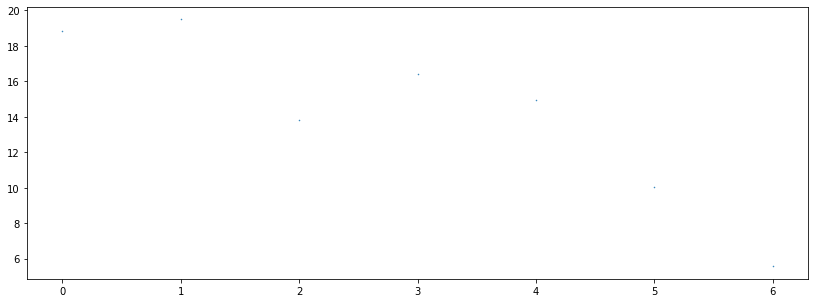

In [180]:
plt.figure(figsize=(14,5))
plt.plot(np.log(pf[1,879:886])-np.log(1-pf[1,879:886]),'.', markersize=1)
# plt.ylim(-100,50)

In [181]:
LL.shape

(1440, 2)

<ipython-input-182-b0a097fda800>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(pf.T)-np.log(1-pf.T),'.', markersize=1)


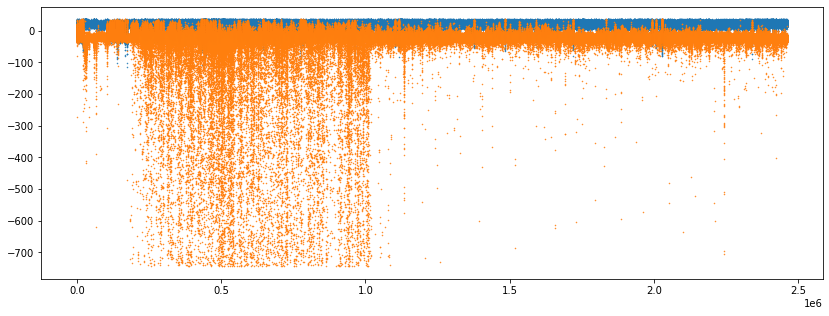

In [182]:
plt.figure(figsize=(14,5))
plt.plot(np.log(pf.T)-np.log(1-pf.T),'.', markersize=1)
# plt.ylim(-100,50)

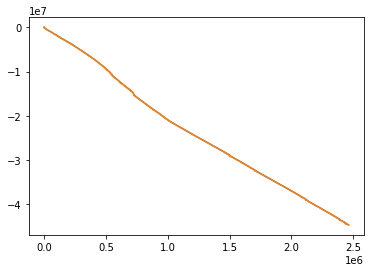

In [183]:
plt.plot(GC.hmm.alpha.T)
# plt.plot(GC.hmm.beta.T)

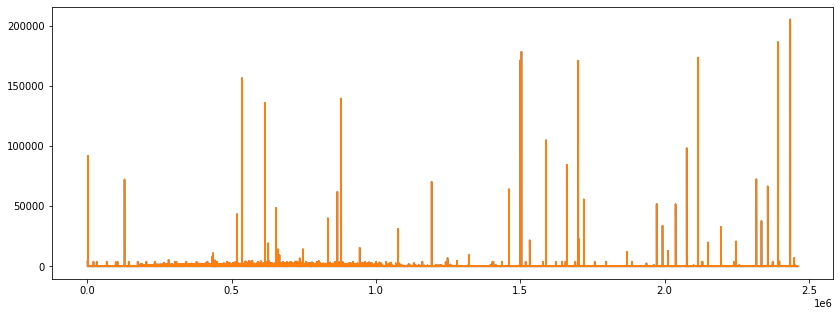

In [184]:
plt.figure(figsize=(14,5))
plt.plot(LLv[:,0]-LLv[:,1], markersize=1)
plt.plot(GC.hmm.alpha[0,:]-GC.hmm.alpha[1,:])

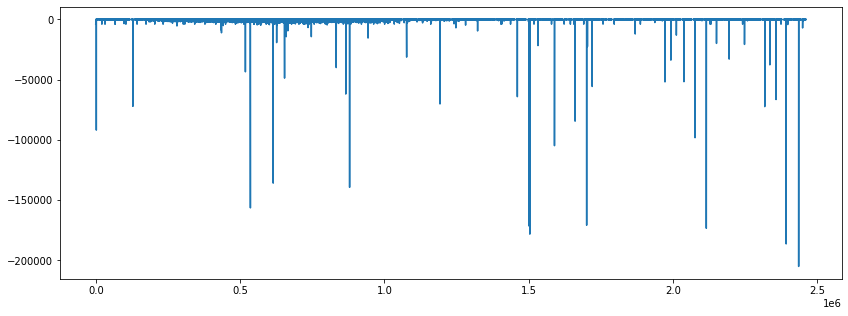

In [185]:
plt.figure(figsize=(14,5))
plt.plot(LLv[:,1]-LLv[:,0], markersize=1)
plt.plot(np.where(np.isfinite(LLv[:,1]-LLv[:,0]),np.nan,1),'*')

plt.plot(np.where(np.isfinite(LLv[:,0]),np.nan,20000),'*')
plt.plot(np.where(np.isfinite(LLv[:,1]),np.nan,10000),'*')

In [186]:
print(GC.hmm.A)
print(GC.hmm.phi)

[[9.99997562e-01 2.43796794e-06]
 [4.22535211e-02 9.57746479e-01]]
[[ -247.60718107  -247.51882057  -247.83037244 ...   -12.64143888
    -13.13367215   -60.14581098]
 [-4102.65662991 -4157.71035082 -4092.1385822  ...   -21.2091908
    -20.00942799   -33.10859413]]


In [187]:
GC.hmm.alpha.dtype

dtype('float64')

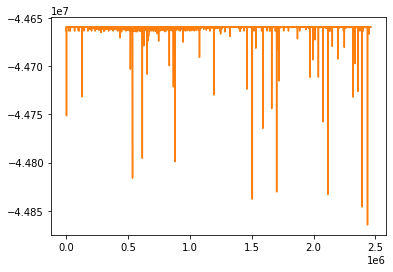

In [188]:
plt.plot(GC.hmm.alpha.T + GC.hmm.beta.T)

(-1000.0, 1000.0)

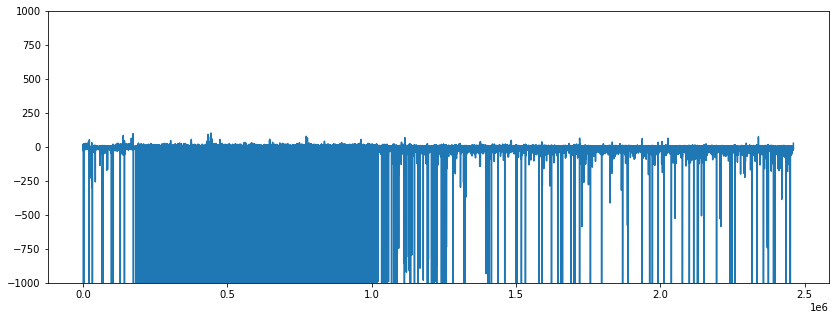

In [189]:
plt.figure(figsize=(14,5))
plt.plot(LLv[:,1]-LLv[:,0], markersize=1)
plt.ylim(-1000,1000)

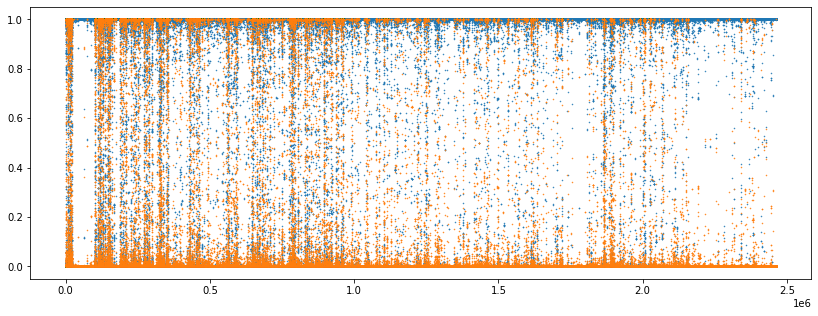

In [190]:
plt.figure(figsize=(14,5))
plt.plot(pf.T,'.', markersize=1)

<ipython-input-191-c9cca1ed1e4f>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(pf.T)-np.log(np.maximum(1-pf.T,1e-12)),'.', markersize=1)


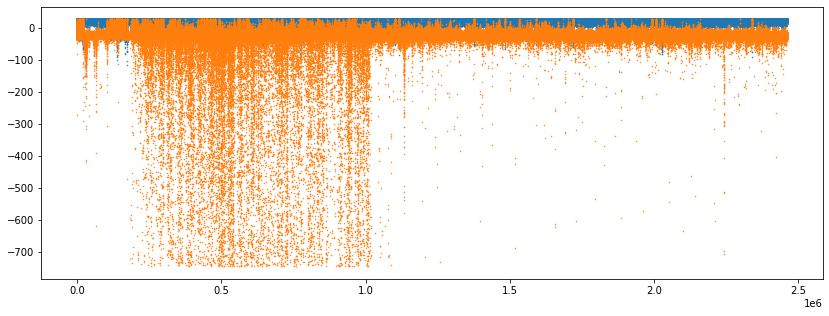

In [191]:
plt.figure(figsize=(14,5))
plt.plot(np.log(pf.T)-np.log(np.maximum(1-pf.T,1e-12)),'.', markersize=1)
# plt.ylim(-100,50)

In [192]:
np.log(np.maximum(1-pf.T,1e-12))

array([[-2.76310211e+01,  0.00000000e+00],
       [-2.76310211e+01,  0.00000000e+00],
       [-2.76310211e+01,  0.00000000e+00],
       ...,
       [-1.55306545e+01, -1.79937837e-07],
       [-6.91973280e+00, -9.88582414e-04],
       [-7.42040096e-07, -1.41138629e+01]])

In [193]:
project.current_animal.annotations.labels

['seizure', 'artefact', 'flatline', 'baseline', '(auto)seizure']

In [194]:
len(project.current_animal.annotations.annotations_list)

110

In [195]:
project.project_file[:-7]

'/media/mfpleite/LaCie_1/ML_pyecog_2/AwesomeProject'

In [196]:
project.save_to_json(fname = project.project_file[:-7]+'_test.pyecog')

In [149]:
# f_vec_d = np.hstack([f_vec, np.vstack([np.zeros(f_vec.shape[1]), np.diff(f_vec, axis=0)])])
LL = GC.log_likelyhoods(f_vec,bias=True,no_scale=False)

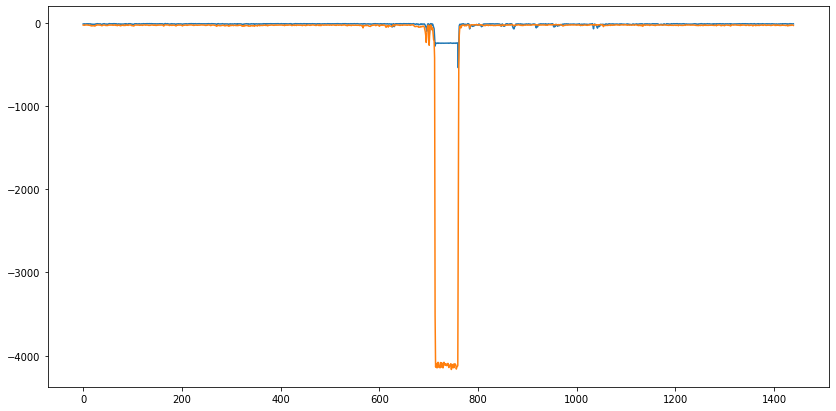

In [150]:
plt.figure(figsize=(14,7))
plt.plot(LL)

In [620]:
print(np.linalg.det(blanks_cov),np.linalg.det(GC.class_cov[0]))

0.000582672948028742 0.28223231073679556


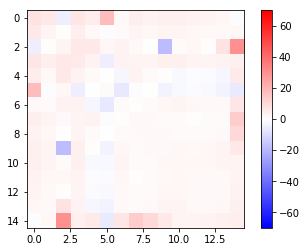

In [621]:
plt.imshow(GC.class_cov[0]/blanks_cov,cmap='bwr',vmin=-70,vmax=70)
plt.colorbar()

In [622]:
@jit(nopython=True)
def LL2prob_jit(LL,prob):
    for i in range(LL.shape[0]):
        v = np.exp(LL[i,:])
        prob[i,:] = v / np.sum(v)
        
def LL2prob(LL):
    prob = np.zeros(LL.shape)
    LL2prob_jit(LL,prob)
    return prob

In [623]:
p = LL2prob(LL)

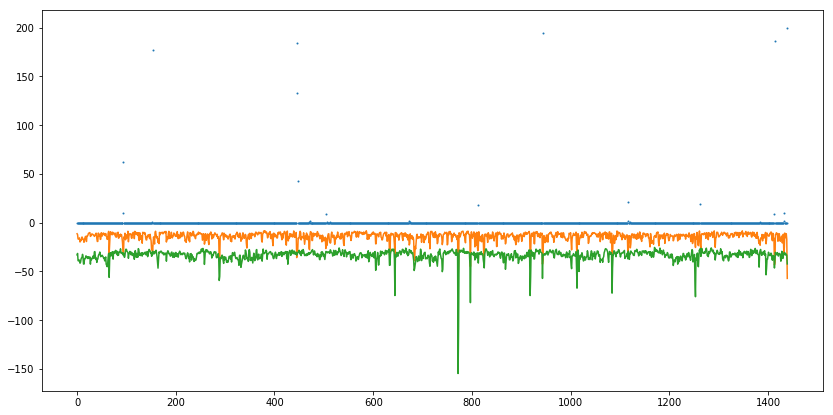

In [624]:
plt.figure(figsize=(14,7))
plt.plot(p[:,1]*200,'.',markersize=2)
plt.plot(LL[:,0])
# plt.plot(b_LLr)
plt.plot(LL[:,1])
# plt.plot(s_LLr)
# plt.vlines(starts[1:],-1000,0,linestyles=':')
# plt.vlines(ends[1:],-1000,0,linestyles=':')
# plt.xlim(400,1000)/

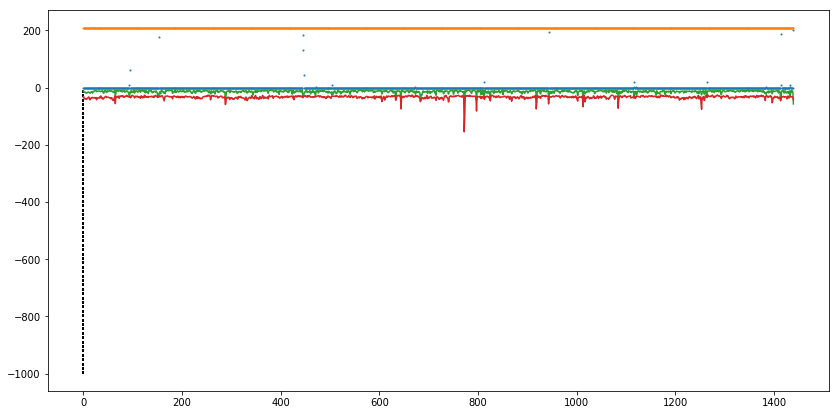

In [625]:
plt.figure(figsize=(14,7))
plt.plot(p[:,1]*200,'.',markersize=2)
plt.plot(p[:,2]*200+210,'.',markersize=2)
plt.plot(LL[:,0])
# plt.plot(b_LLr)
plt.plot(LL[:,1])
# plt.plot(s_LLr)
plt.vlines(starts[1:],-1000,0,linestyles=':')
plt.vlines(ends[1:],-1000,0,linestyles=':')
# plt.xlim(400,1000)/

In [699]:
LLv = []
R2v = []
drawplots = False

project.current_animal.eeg_files.sort()
for eegfname in project.current_animal.eeg_files:
    fname = '.'.join(eegfname.split('.')[:-1]+['features'])
    f_vec = np.fromfile(fname,dtype='float64')
    f_vec = f_vec.reshape((-1,fe.settings['number_of_features']))
#     f_vec = np.hstack([f_vec, np.vstack([np.zeros(f_vec.shape[1]), np.diff(f_vec, axis=0)])])
    LL = GC.log_likelyhoods(f_vec,bias=False,no_scale=False)
    R2 = GC.log_likelyhoods(f_vec,bias=False,no_scale=True)
    LLv.append(LL)
    R2v.append(R2)
    p  = LL2prob(LL) 
    if drawplots:
        plt.figure(figsize=(14,7))
        plt.plot(p[:,1]*200,'.',markersize=2)
        plt.plot(LL[:,0],'.',markersize=2)
        plt.plot(LL[:,1],'.',markersize=2)
        plt.vlines(starts[1:],-1000,0,linestyles=':')
        plt.vlines(ends[1:],-1000,0,linestyles=':')
        plt.title(eegfname)
        plt.show()
    # plt.xlim(400,1000)

    
LLv = np.vstack(LLv)
R2v = np.vstack(R2v)
pv  = LL2prob(LLv) 

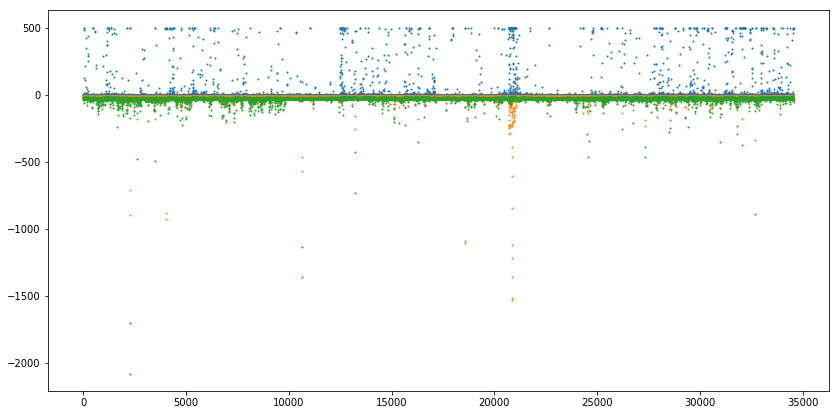

In [700]:
plt.figure(figsize=(14,7))
plt.plot(pv[:,1]*500,'.',markersize=2)
plt.plot(LLv[:,0],'.',markersize=2)
plt.plot(LLv[:,1],'.',markersize=2)
# plt.vlines(starts[1:],-1000,0,linestyles=':')
# plt.vlines(ends[1:],-1000,0,linestyles=':')

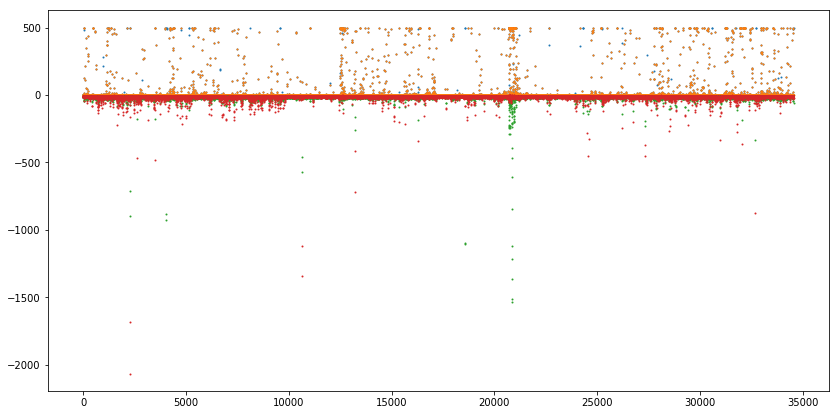

In [701]:
th = stats.chi2.isf(1e-3,15,scale=0.5)
plt.figure(figsize=(14,7))


plt.plot(pv[:,1]*500,'.',markersize=2)
plt.plot((pv[:,1]*(-R2v[:,1]<th))*500,'.',markersize=2)
# plt.plot((-R2v[:,1]<th)*500,'-',markersize=2)
plt.plot(R2v[:,0],'.',markersize=2)
plt.plot(R2v[:,1],'.',markersize=2)

In [645]:
@jit(nopython=True)
def LL2prob_jit(LL,prob):
    for i in range(LL.shape[0]):
        v = np.exp(LL[i,:])
        prob[i,:] = v / np.sum(v)
        
def LL2prob(LL):
    prob = np.zeros(LL.shape)
    LL2prob_jit(LL,prob)
    return prob

In [646]:
import hmm_pyecog
importlib.reload(hmm_pyecog)

<module 'hmm_pyecog' from '../hmm_pyecog.py'>

In [647]:
# HMM = hmm_pyecog.HMM_LL()
HMM = GC.hmm

In [649]:
HMM.A

array([[9.99956519e-01, 4.34807815e-05, 0.00000000e+00],
       [4.83870968e-02, 9.51612903e-01, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [702]:
p  = LL2prob(LLv).T
pf = HMM.forward_backward(LLv.T)
starts = np.diff(((pf[1,:].T*(-R2v[:,1]<th)))>.5)>0
ends =  np.diff(((pf[1,:].T*(-R2v[:,1]<th))>.5).astype('int'))<0

../hmm_pyecog.py:245: RuntimeWarning: divide by zero encountered in log
  alpha[:, 0] = log_phi[:, 0] + np.log(stationary_dist)
../hmm_pyecog.py:249: RuntimeWarning: divide by zero encountered in log
  alpha_t = log_phi[:, t] + np.log(np.dot(exp_alpha_t.T, A))  # sure no undeflow here...
../hmm_pyecog.py:284: RuntimeWarning: divide by zero encountered in log
  beta[:, t] = np.log(beta_t) + max_beta_t


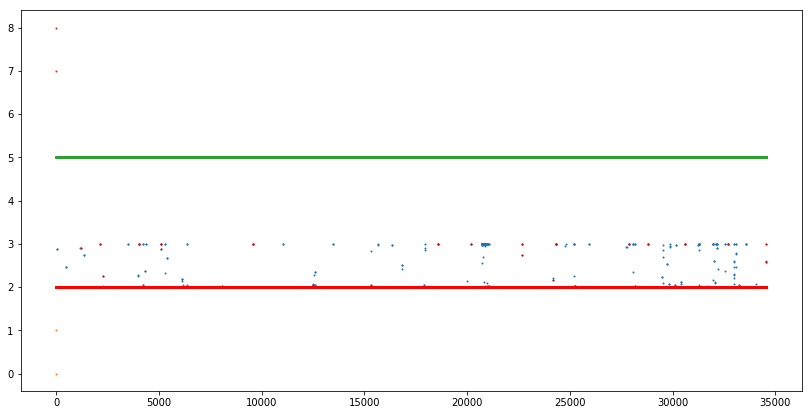

In [753]:
plt.figure(figsize=(14,7))
plt.plot(pf[1,:].T+2,'.',markersize=2)
plt.plot((pf[1,:].T*(-R2v[:,1]>th))+2,'r.',markersize=2)
plt.plot(p[1,:].T,'.',markersize=2)
plt.plot(pf[2,:].T+5,'.',markersize=2)
plt.plot(p[2,:].T+7,'.',markersize=2)
# plt.plot(p[1,:].T-pf[1,:].T-2,'.',markersize=2)

th = stats.chi2.isf(1e-3,15,scale=0.5)
# plt.xlim(20000,22050)

In [754]:
np.sum(np.diff((pf[1,:]>.5).astype('int')>0))


123

In [755]:
starts = np.nonzero(np.diff(((pf[1,:].T*(-R2v[:,1]<th))>.5).astype('int'))>0)[0]
ends =   np.nonzero(np.diff(((pf[1,:].T*(-R2v[:,1]<th))>.5).astype('int'))<0)[0]

In [756]:
len(starts)

55

In [757]:
np.tile(np.eye(10),(5,1,1)).shape

(5, 10, 10)

(20600, 21500)

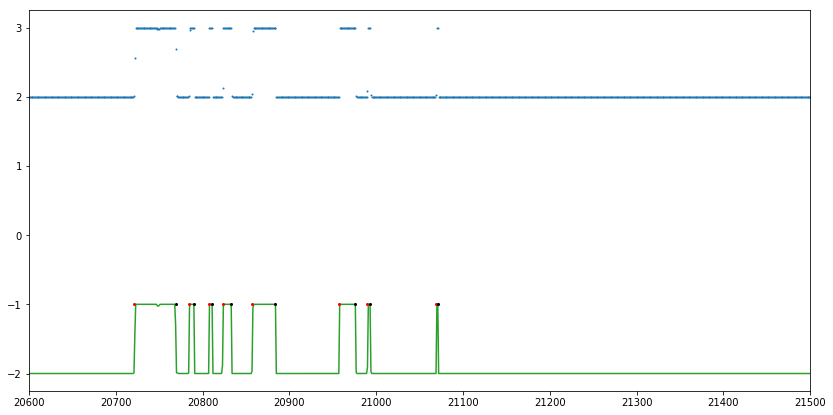

In [759]:
r = (20600,21500)

plt.figure(figsize=(14,7))
plt.plot(pf[1,:].T+2,'.',markersize=2)
plt.plot(p[1,:].T,'.',markersize=2)
# plt.plot(p[1,:].T-pf[1,:].T-2,'.',markersize=2)

th = stats.chi2.isf(1e-3,15,scale=0.5)
plt.plot((pf[1,:].T*(-R2v[:,1]<th))-2,'-',markersize=2)
plt.plot(starts,starts*0-1,'o',markersize=2,color='r')
plt.plot(ends,ends*0-1,'o',markersize=2,color='k')
plt.xlim(*r)

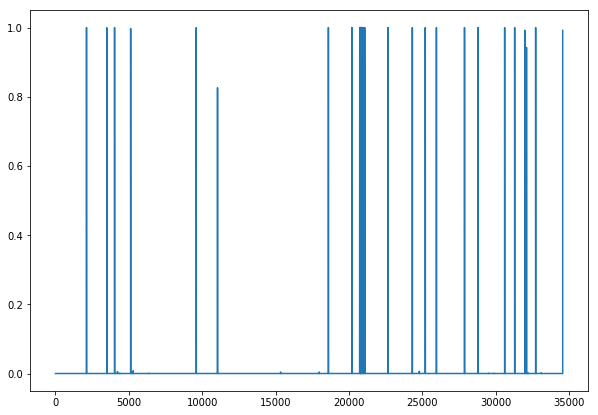

In [125]:
plt.figure(figsize=(10,7))
plt.plot(pf[1,:])
plt.show()

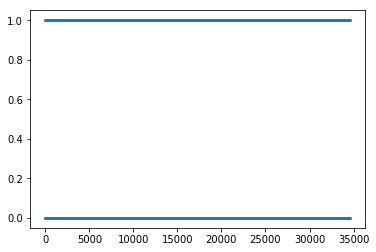

In [126]:
th = stats.chi2.isf(1e-1,15,scale=0.5)
plt.plot((-R2v[:,1]<th),'.',markersize=2)

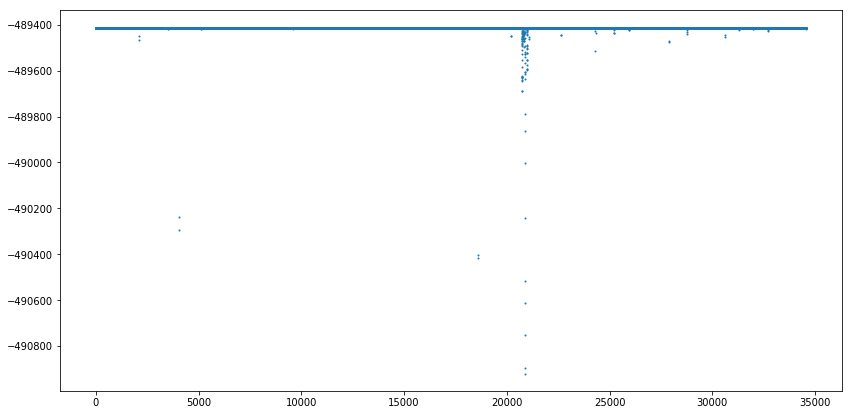

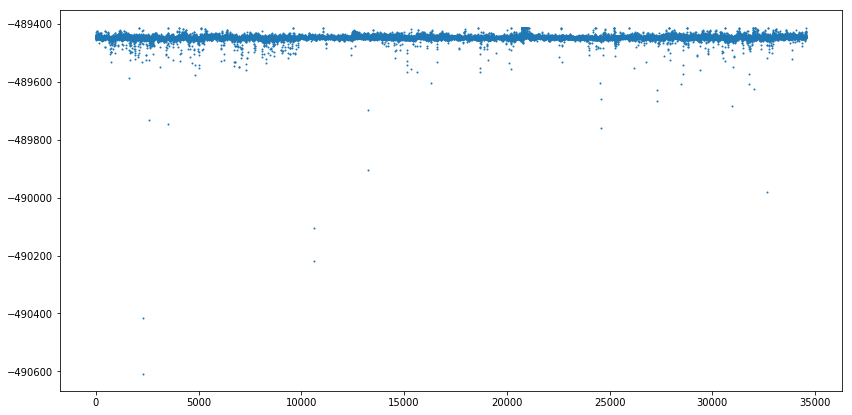

In [127]:

plt.figure(figsize=(14,7))
plt.plot((HMM.alpha[0,:] + HMM.beta[0,:]).T,'.',markersize=2)
plt.figure(figsize=(14,7))
plt.plot((HMM.alpha[1,:] + HMM.beta[1,:]).T,'.',markersize=2)

(20000, 22000)

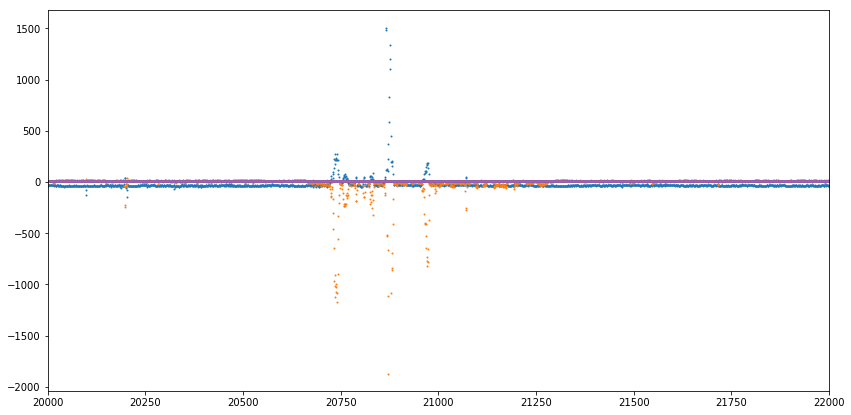

In [128]:
plt.figure(figsize=(14,7))
plt.plot(np.diff(HMM.beta.T+HMM.alpha.T,axis=1),'.',markersize=2)

plt.plot(HMM.posterior.T+10,'.',markersize=2)
plt.xlim(20000,22000)

/home/mfpleite/anaconda3/envs/pyecog2_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/mfpleite/anaconda3/envs/pyecog2_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


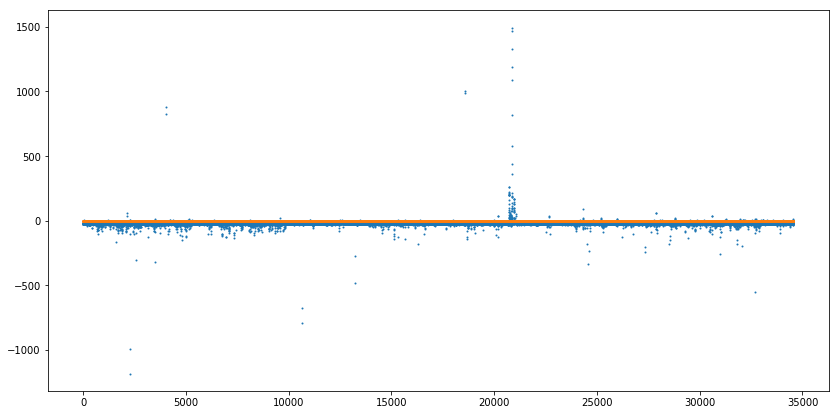

In [129]:
plt.figure(figsize=(14,7))
# plt.plot(pv[:,1]*500,'.',markersize=2)
plt.plot(LLv[:,1] - LLv[:,0],'.',markersize=2)
plt.plot(np.exp(LLv[:,1] - LLv[:,0])/np.exp(LLv[:,1] - LLv[:,0]),'.',markersize=2)
# plt.plot(LLv[:,1],'.',markersize=2)
# plt.plot(HMM.phi.T,'.',markersize=2)
# plt.xlim(20000,22000)

In [130]:
LLf =(HMM.alpha+HMM.beta).T

In [131]:
dLLf = np.diff(LLf,axis=1)
dLLv = np.diff(LLv,axis=1)

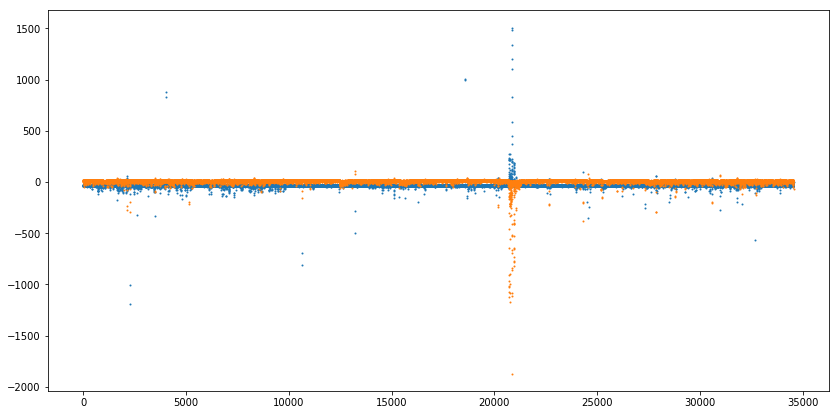

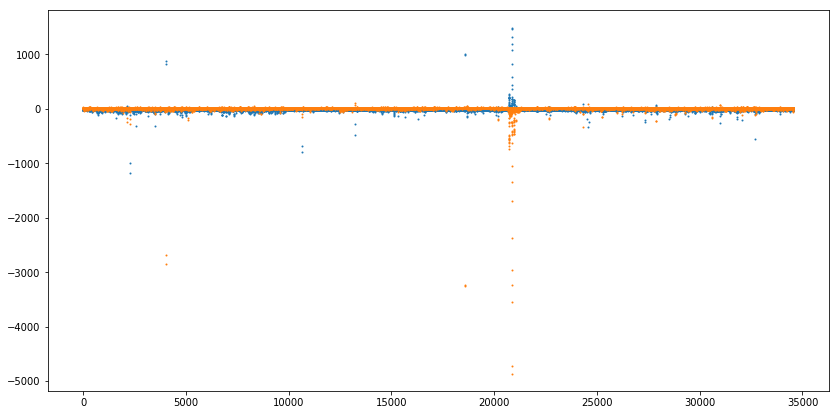

In [132]:
plt.figure(figsize=(14,7))
plt.plot(dLLf,'.',markersize=2)
plt.figure(figsize=(14,7))
plt.plot(dLLv,'.',markersize=2)

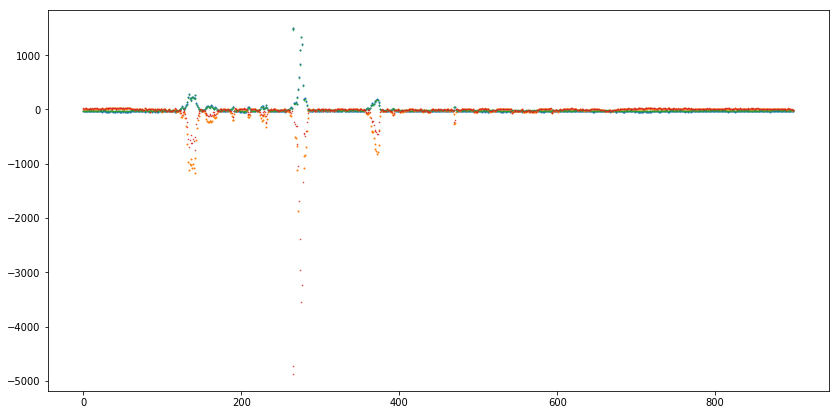

In [133]:
r = range(20600,21500)
plt.figure(figsize=(14,7))
plt.plot(dLLf[r],'.',markersize=2)
plt.plot(dLLv[r],'.',markersize=1)


In [405]:
a = {'b':[[1,2],[6,7]],
     'c':[[2,3],[8,9]]
    }
keys = ['b','c']

In [412]:
d = [(l[0],l[1],i+1) for i,key in enumerate(keys) for l in a[key]]
d

[(1, 2, 1), (6, 7, 1), (2, 3, 2), (8, 9, 2)]

In [413]:
d.sort()
d

[(1, 2, 1), (2, 3, 2), (6, 7, 1), (8, 9, 2)]

In [481]:
dt=.5
def transitions2matrix(t,dt,n):
    A = np.zeros((n+1,n+1))
    A[0,d[0][2]] +=1
    for i in range(len(t)-1):
        if t[i][1] >= t[i+1][0]-dt: # transitions between labled events
            A[t[i][2],t[i+1][2]] +=1
        else:  # transitions between labled events and blanks
            A[t[i][2],0]   +=1
            A[0,t[i+1][2]] += 1
    return A

def tansitions2rates(B,nblankpoints,nclasspoints):
    A = B
    A[0,0] = nblankpoints - np.sum(A[0,:])
    A[0,:] /= np.sum(A[0,:])
    for i in range(len(nclasspoints)):
        if nclasspoints[i]:
            A[i+1,i+1] = nclasspoints[i] - np.sum(A[i+1,:])
            A[i+1,:] /= np.sum(A[i+1,:])
        else: # For classes that do not occur, default to transition to blanks
            A[i+1,:] = 0
            A[i+1,0] = 1
    return A

In [482]:
A = np.zeros((3,3),dtype='float64')
A = transitions2matrix(d,.5,3)

In [483]:
B  = tansitions2rates(A,100,[10,5,0])

In [484]:
B

array([[0.97, 0.02, 0.01, 0.  ],
       [0.1 , 0.8 , 0.1 , 0.  ],
       [0.2 , 0.  , 0.8 , 0.  ],
       [1.  , 0.  , 0.  , 0.  ]])

In [661]:
tv = []
for i in range(10):
    t =np.arange(100)
    tv.append(t)
tvs = np.hstack(tv)

In [662]:
tvs.shape

(1000,)

In [3]:
6//10

0

In [4]:
1.58496687e+09

1584966870.0

In [5]:
1572565228.494363 + 3600

1572568828.494363